# PyG (pytorch-geometric) tutorial
- source: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

```
PyTorch and torchvision define an example as a tuple of an image and a target. We omit this notation in PyG to allow for various data structures in a clean and understandable way.
```

In [1]:
# CUDA="cpu"
# pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+${CUDA}.html
# pip install torch-geometric


In [45]:
import sys
import platform

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import networkx as nx
import matplotlib.pyplot as plt

In [4]:
print("Platform", platform.system(), platform.release())
print("Python version",sys.version)

print("torch",torch.__version__)
print("torch_geomeric",torch_geometric.__version__)


Platform Darwin 22.3.0
Python version 3.8.12 (default, Jul 12 2022, 16:17:42) 
[Clang 13.1.6 (clang-1316.0.21.2.5)]
torch 1.13.1
torch_geomeric 2.2.0


In [36]:
## helper functions

def vis_graph(data,figsize=(10,10)):
    vis_graph = torch_geometric.utils.convert.to_networkx(data)
    vis_labels = list(vis_graph.nodes)

    plt.figure(1,figsize=figsize) 
    nx.draw(vis_graph, 
            cmap=plt.get_cmap('Set1'),
            node_color = vis_labels,
            node_size=75,
            linewidths=6,
            with_labels = True)
    plt.show()

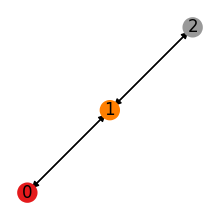

In [37]:
# eample graph
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

vis_graph(data=data,figsize=(2,2))


In [43]:
# Official toy dataset (a series of grpahs
dataset = Planetoid(root='/tmp/Cora', name='Cora')


In [46]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [48]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

In [49]:
acc

0.794